# Import Libraries

In [1]:
import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, Flatten, Dense, Dropout, Input
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from keras.models import Model
from keras.layers.merge import concatenate

from PIL import ImageFile   
from sklearn.model_selection import train_test_split
from keras.preprocessing import image                  
from tqdm import tqdm

from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50

# Defining the train,test and model directories

In [2]:
TEST_DIR = 'imgs/test'
TRAIN_DIR = 'imgs/train'
MODEL_PATH = 'model/VGG16'
PICKLE_PATH = 'pickle'
CSV_DIR = 'csv_files'

In [3]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model VGG16 path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model VGG16 path created")
if not os.path.exists(PICKLE_PATH):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

# Data Preparation

In [4]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv('csv_files/' + filename, index=False)

create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")
data_train = pd.read_csv('csv_files/train.csv')
data_test = pd.read_csv('csv_files/test.csv')

In [5]:
data_train = pd.read_csv('csv_files/train.csv')
data_test = pd.read_csv('csv_files/test.csv')

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filename   22424 non-null  object
 1   ClassName  22424 non-null  object
dtypes: object(2)
memory usage: 350.5+ KB


In [6]:
data_train['ClassName'].value_counts()

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: ClassName, dtype: int64

In [9]:
data_train.describe()

,Filename,ClassName
count,22424,22424
unique,22424,10
top,imgs/train\c5\img_56696.jpg,c0
freq,1,2489


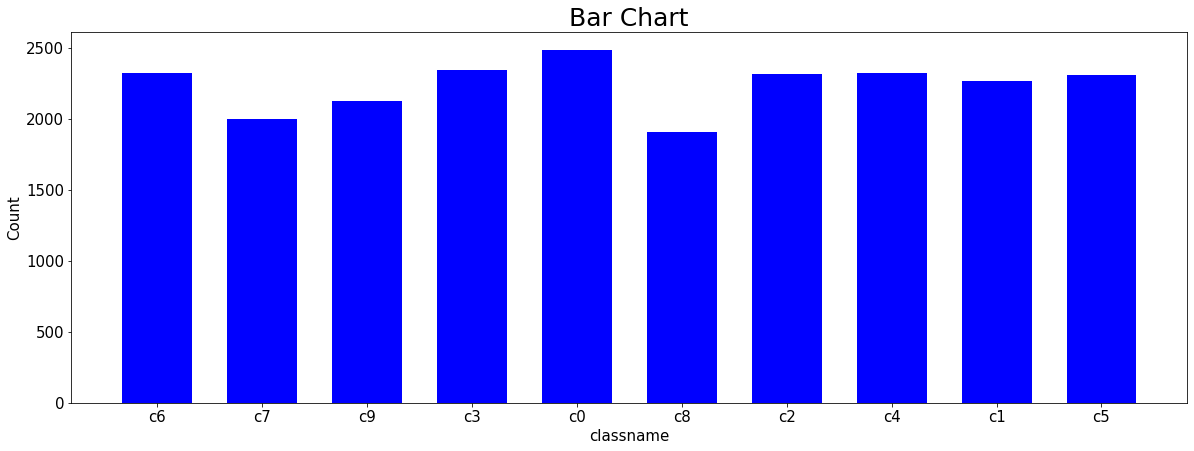

In [10]:
nf = data_train['ClassName'].value_counts(sort=False)
labels = data_train['ClassName'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

In [11]:
data_test.head()

,FileName,ClassName
0,imgs/test\img_1.jpg,test
1,imgs/test\img_10.jpg,test
2,imgs/test\img_100.jpg,test
3,imgs/test\img_1000.jpg,test
4,imgs/test\img_100000.jpg,test


In [12]:
data_test.shape

(79726, 2)

### Converting into numerical values

In [7]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c5': 0, 'c3': 1, 'c2': 2, 'c4': 3, 'c1': 4, 'c6': 5, 'c9': 6, 'c0': 7, 'c7': 8, 'c8': 9}


In [8]:
with open('pickle/labels_list.pkl', "wb") as handle:
    pickle.dump(labels_id,handle)

In [9]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)

(22424, 10)


# Splitting into Train and Test sets

In [10]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)

### Converting into 128*128 images

In [11]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(128, 128))
    # convert PIL.Image.Image type to 3D tensor with shape (128, 128, 3)
    x = image.img_to_array(img)
   # convert 3D tensor to 4D tensor with shape (1, 128, 128, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|██████████████████████████████████████████████████████████████████████████████| 4485/4485 [01:17<00:00, 57.71it/s]


In [13]:
print(train_tensors.shape)

(17939, 128, 128, 3)


# VGG16

In [14]:
model = VGG16(include_top=False, input_shape=(128,128,3))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [15]:
train_vgg16 = model.predict(train_tensors,verbose=1)
valid_vgg16 = model.predict(valid_tensors,verbose=1)

141/141 [==============================] - 6s 41ms/step


In [16]:
print("Train shape",train_vgg16.shape)
print("Validation shape",valid_vgg16.shape)

Train shape (17939, 4, 4, 512)
Validation shape (4485, 4, 4, 512)


In [17]:
train_features = train_vgg16[0]
valid_features = valid_vgg16[0]

In [18]:
print("Train features shape",train_features.shape)
print("Validation features shape",valid_features.shape)

Train features shape (4, 4, 512)
Validation features shape (4, 4, 512)


In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_features.shape))
VGG16_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 5,130
Trainable params: 5,130
Non-trainable params: 0
_________________________________________________________________


In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [22]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [23]:
model_history = VGG16_model.fit(train_vgg16,ytrain,validation_data = (valid_vgg16, ytest),epochs=400, batch_size=16, shuffle=True,callbacks=callbacks_list)

Epoch 1/400
1122/1122 [==============================] - 10s 3ms/step - loss: 2.0691 - accuracy: 0.3158 - val_loss: 1.5746 - val_accuracy: 0.6011

Epoch 00001: val_accuracy improved from -inf to 0.60111, saving model to model/VGG16\distracted-01-0.60.hdf5
Epoch 2/400
1122/1122 [==============================] - 3s 3ms/step - loss: 1.4433 - accuracy: 0.6685 - val_loss: 1.2161 - val_accuracy: 0.7070

Epoch 00002: val_accuracy improved from 0.60111 to 0.70702, saving model to model/VGG16\distracted-02-0.71.hdf5
Epoch 3/400
1122/1122 [==============================] - 4s 3ms/step - loss: 1.1245 - accuracy: 0.7632 - val_loss: 0.9751 - val_accuracy: 0.8042

Epoch 00003: val_accuracy improved from 0.70702 to 0.80424, saving model to model/VGG16\distracted-03-0.80.hdf5
Epoch 4/400
1122/1122 [==============================] - 4s 3ms/step - loss: 0.9282 - accuracy: 0.8118 - val_loss: 0.8401 - val_accuracy: 0.8185

Epoch 00004: val_accuracy improved from 0.80424 to 0.81851, saving model to model/

1122/1122 [==============================] - 3s 3ms/step - loss: 0.2002 - accuracy: 0.9532 - val_loss: 0.2181 - val_accuracy: 0.9452

Epoch 00035: val_accuracy did not improve from 0.94515
Epoch 36/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.1909 - accuracy: 0.9547 - val_loss: 0.2127 - val_accuracy: 0.9478

Epoch 00036: val_accuracy improved from 0.94515 to 0.94783, saving model to model/VGG16\distracted-36-0.95.hdf5
Epoch 37/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.1936 - accuracy: 0.9521 - val_loss: 0.2140 - val_accuracy: 0.9449

Epoch 00037: val_accuracy did not improve from 0.94783
Epoch 38/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.1931 - accuracy: 0.9545 - val_loss: 0.2057 - val_accuracy: 0.9492

Epoch 00038: val_accuracy improved from 0.94783 to 0.94916, saving model to model/VGG16\distracted-38-0.95.hdf5
Epoch 39/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.1838 - accu

1122/1122 [==============================] - 3s 3ms/step - loss: 0.1272 - accuracy: 0.9672 - val_loss: 0.1602 - val_accuracy: 0.9550

Epoch 00073: val_accuracy did not improve from 0.95786
Epoch 74/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.1311 - accuracy: 0.9670 - val_loss: 0.1513 - val_accuracy: 0.9567

Epoch 00074: val_accuracy did not improve from 0.95786
Epoch 75/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.1265 - accuracy: 0.9704 - val_loss: 0.1546 - val_accuracy: 0.9552

Epoch 00075: val_accuracy did not improve from 0.95786
Epoch 76/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.1324 - accuracy: 0.9673 - val_loss: 0.1506 - val_accuracy: 0.9561

Epoch 00076: val_accuracy did not improve from 0.95786
Epoch 77/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.1271 - accuracy: 0.9686 - val_loss: 0.1488 - val_accuracy: 0.9585

Epoch 00077: val_accuracy improved from 0.95786 to 0.95853

1122/1122 [==============================] - 3s 3ms/step - loss: 0.1050 - accuracy: 0.9742 - val_loss: 0.1345 - val_accuracy: 0.9614

Epoch 00111: val_accuracy did not improve from 0.96299
Epoch 112/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.1042 - accuracy: 0.9762 - val_loss: 0.1366 - val_accuracy: 0.9592

Epoch 00112: val_accuracy did not improve from 0.96299
Epoch 113/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.1070 - accuracy: 0.9732 - val_loss: 0.1318 - val_accuracy: 0.9616

Epoch 00113: val_accuracy did not improve from 0.96299
Epoch 114/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0983 - accuracy: 0.9771 - val_loss: 0.1311 - val_accuracy: 0.9623

Epoch 00114: val_accuracy did not improve from 0.96299
Epoch 115/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0960 - accuracy: 0.9756 - val_loss: 0.1361 - val_accuracy: 0.9588

Epoch 00115: val_accuracy did not improve from 0.96299

1122/1122 [==============================] - 3s 3ms/step - loss: 0.0861 - accuracy: 0.9769 - val_loss: 0.1257 - val_accuracy: 0.9630

Epoch 00151: val_accuracy did not improve from 0.96477
Epoch 152/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0967 - accuracy: 0.9765 - val_loss: 0.1251 - val_accuracy: 0.9643

Epoch 00152: val_accuracy did not improve from 0.96477
Epoch 153/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0927 - accuracy: 0.9775 - val_loss: 0.1305 - val_accuracy: 0.9590

Epoch 00153: val_accuracy did not improve from 0.96477
Epoch 154/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0868 - accuracy: 0.9781 - val_loss: 0.1225 - val_accuracy: 0.9639

Epoch 00154: val_accuracy did not improve from 0.96477
Epoch 155/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0860 - accuracy: 0.9787 - val_loss: 0.1247 - val_accuracy: 0.9628

Epoch 00155: val_accuracy did not improve from 0.96477

1122/1122 [==============================] - 3s 3ms/step - loss: 0.0825 - accuracy: 0.9796 - val_loss: 0.1211 - val_accuracy: 0.9648

Epoch 00191: val_accuracy did not improve from 0.96522
Epoch 192/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0838 - accuracy: 0.9779 - val_loss: 0.1250 - val_accuracy: 0.9608

Epoch 00192: val_accuracy did not improve from 0.96522
Epoch 193/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0719 - accuracy: 0.9810 - val_loss: 0.1211 - val_accuracy: 0.9639

Epoch 00193: val_accuracy did not improve from 0.96522
Epoch 194/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0768 - accuracy: 0.9806 - val_loss: 0.1226 - val_accuracy: 0.9630

Epoch 00194: val_accuracy did not improve from 0.96522
Epoch 195/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0777 - accuracy: 0.9814 - val_loss: 0.1222 - val_accuracy: 0.9648

Epoch 00195: val_accuracy did not improve from 0.96522

1122/1122 [==============================] - 3s 3ms/step - loss: 0.0747 - accuracy: 0.9800 - val_loss: 0.1213 - val_accuracy: 0.9628

Epoch 00231: val_accuracy did not improve from 0.96589
Epoch 232/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0669 - accuracy: 0.9840 - val_loss: 0.1200 - val_accuracy: 0.9630

Epoch 00232: val_accuracy did not improve from 0.96589
Epoch 233/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0749 - accuracy: 0.9827 - val_loss: 0.1196 - val_accuracy: 0.9643

Epoch 00233: val_accuracy did not improve from 0.96589
Epoch 234/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0704 - accuracy: 0.9830 - val_loss: 0.1209 - val_accuracy: 0.9630

Epoch 00234: val_accuracy did not improve from 0.96589
Epoch 235/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0799 - accuracy: 0.9818 - val_loss: 0.1203 - val_accuracy: 0.9628

Epoch 00235: val_accuracy did not improve from 0.96589

1122/1122 [==============================] - 3s 3ms/step - loss: 0.0707 - accuracy: 0.9826 - val_loss: 0.1183 - val_accuracy: 0.9637

Epoch 00271: val_accuracy did not improve from 0.96656
Epoch 272/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0710 - accuracy: 0.9832 - val_loss: 0.1193 - val_accuracy: 0.9643

Epoch 00272: val_accuracy did not improve from 0.96656
Epoch 273/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0678 - accuracy: 0.9826 - val_loss: 0.1213 - val_accuracy: 0.9652

Epoch 00273: val_accuracy did not improve from 0.96656
Epoch 274/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0665 - accuracy: 0.9828 - val_loss: 0.1231 - val_accuracy: 0.9630

Epoch 00274: val_accuracy did not improve from 0.96656
Epoch 275/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0641 - accuracy: 0.9849 - val_loss: 0.1201 - val_accuracy: 0.9650

Epoch 00275: val_accuracy did not improve from 0.96656

1122/1122 [==============================] - 3s 3ms/step - loss: 0.0640 - accuracy: 0.9846 - val_loss: 0.1242 - val_accuracy: 0.9630

Epoch 00311: val_accuracy did not improve from 0.96656
Epoch 312/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0625 - accuracy: 0.9847 - val_loss: 0.1240 - val_accuracy: 0.9614

Epoch 00312: val_accuracy did not improve from 0.96656
Epoch 313/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0652 - accuracy: 0.9851 - val_loss: 0.1265 - val_accuracy: 0.9619

Epoch 00313: val_accuracy did not improve from 0.96656
Epoch 314/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0685 - accuracy: 0.9839 - val_loss: 0.1243 - val_accuracy: 0.9628

Epoch 00314: val_accuracy did not improve from 0.96656
Epoch 315/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0578 - accuracy: 0.9868 - val_loss: 0.1251 - val_accuracy: 0.9616

Epoch 00315: val_accuracy did not improve from 0.96656

1122/1122 [==============================] - 3s 3ms/step - loss: 0.0597 - accuracy: 0.9850 - val_loss: 0.1214 - val_accuracy: 0.9637

Epoch 00351: val_accuracy did not improve from 0.96656
Epoch 352/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0662 - accuracy: 0.9832 - val_loss: 0.1232 - val_accuracy: 0.9637

Epoch 00352: val_accuracy did not improve from 0.96656
Epoch 353/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0647 - accuracy: 0.9844 - val_loss: 0.1226 - val_accuracy: 0.9634

Epoch 00353: val_accuracy did not improve from 0.96656
Epoch 354/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0629 - accuracy: 0.9851 - val_loss: 0.1209 - val_accuracy: 0.9648

Epoch 00354: val_accuracy did not improve from 0.96656
Epoch 355/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0599 - accuracy: 0.9856 - val_loss: 0.1227 - val_accuracy: 0.9643

Epoch 00355: val_accuracy did not improve from 0.96656

1122/1122 [==============================] - 3s 3ms/step - loss: 0.0543 - accuracy: 0.9875 - val_loss: 0.1245 - val_accuracy: 0.9641

Epoch 00391: val_accuracy did not improve from 0.96656
Epoch 392/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0557 - accuracy: 0.9863 - val_loss: 0.1245 - val_accuracy: 0.9634

Epoch 00392: val_accuracy did not improve from 0.96656
Epoch 393/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0588 - accuracy: 0.9856 - val_loss: 0.1243 - val_accuracy: 0.9639

Epoch 00393: val_accuracy did not improve from 0.96656
Epoch 394/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0551 - accuracy: 0.9867 - val_loss: 0.1227 - val_accuracy: 0.9645

Epoch 00394: val_accuracy did not improve from 0.96656
Epoch 395/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0536 - accuracy: 0.9875 - val_loss: 0.1227 - val_accuracy: 0.9641

Epoch 00395: val_accuracy did not improve from 0.96656

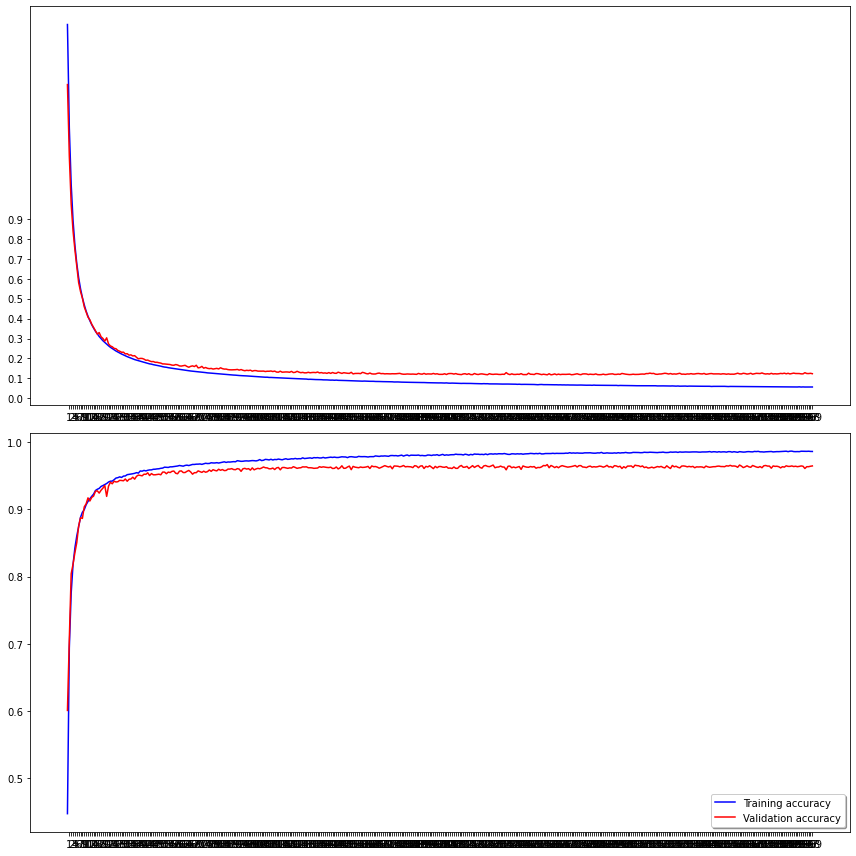

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 400, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 400, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### Model Analysis

In [25]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [26]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [27]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = VGG16_model.predict(valid_vgg16,verbose=1)

141/141 [==============================] - 0s 1ms/step


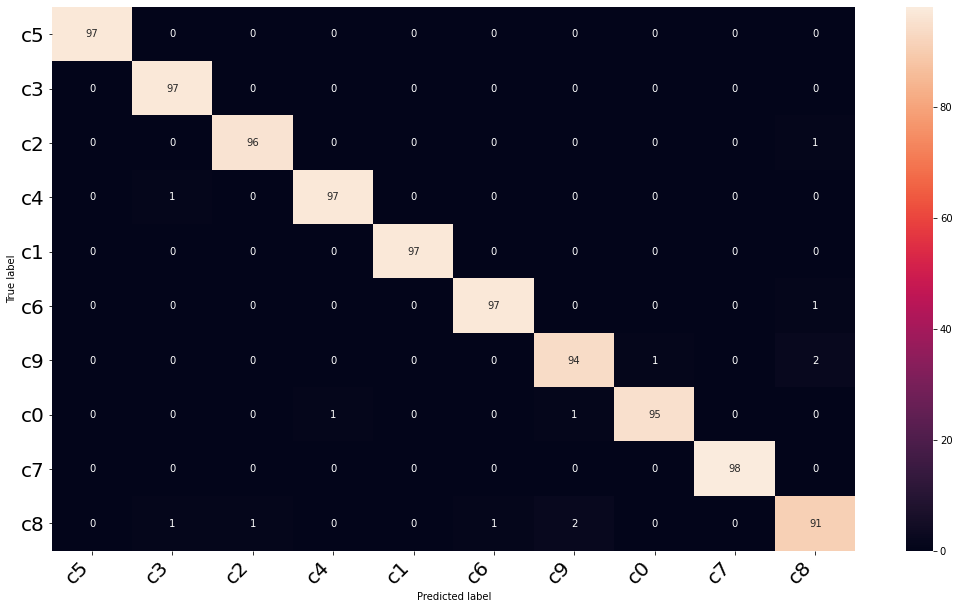

In [28]:
print_heatmap(ytest,ypred,class_names)

### Precision Recall F1 Score

In [29]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [30]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.964548
Precision: 0.964576
Recall: 0.964548
F1 score: 0.964548
